# 0. Initialize

In [ ]:
#@title Connect to gDrive & Load Files
ENV_COLAB = 'google.colab' in str(get_ipython())
if ENV_COLAB:
    print('Running on CoLab')
    PROJECT_DRIVE_FOLDER= "/content/drive/MyDrive/NiPAMS/BP development/analysis/nipams-bp-py-main/" #@param {"type":"string"}
    ## Load this for local development version of library.. Loads from GoogleDrive (changes persist)
    from google.colab import drive, widgets, data_table; 
    drive.mount('/content/drive');
    %cd "$PROJECT_DRIVE_FOLDER"
  
    !pip install -qr requirements.txt
    !pip install -q envyaml
    import os, sys; 
    from envyaml import EnvYAML; env = EnvYAML('env/default.yml'); 
    for k,v in env.export().items(): os.environ[k]=str(v)
    sys.path.append(os.path.abspath("./src"))

else:
    print('Not running on CoLab')
    %cd /app
!pwd

from importlib import reload;
from utils.constants import *

Running on CoLab
Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1MnayBGJfAervEVUyYNEibuPedW7NJuzm/NiPAMS/BP development/analysis/nipams-bp-py-main
     |████████████████████████████████| 210 kB 5.6 MB/s 
     |████████████████████████████████| 226 kB 33.0 MB/s 
     |████████████████████████████████| 9.6 MB 42.4 MB/s 
     |████████████████████████████████| 175 kB 79.5 MB/s 
     |████████████████████████████████| 357 kB 89.1 MB/s 
/content/drive/.shortcut-targets-by-id/1MnayBGJfAervEVUyYNEibuPedW7NJuzm/NiPAMS/BP development/analysis/nipams-bp-py-main


In [ ]:
!pip install tsai -Uq
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

     |████████████████████████████████| 234 kB 4.3 MB/s 
     |████████████████████████████████| 188 kB 32.5 MB/s 
     |████████████████████████████████| 2.5 MB 53.3 MB/s 
     |████████████████████████████████| 60 kB 9.1 MB/s 
tsai       : 0.3.0
fastai     : 2.5.6
fastcore   : 1.4.2
torch      : 1.10.0+cu111


In [ ]:
from data import load_data, preprocess; reload(load_data);reload(preprocess)
from models import experiments; reload(experiments)

<module 'models.experiments' from '/content/drive/.shortcut-targets-by-id/1MnayBGJfAervEVUyYNEibuPedW7NJuzm/NiPAMS/BP development/analysis/nipams-bp-py-main/src/models/experiments.py'>

# 1. Load & Process Data

In [23]:
dfBpCont, dfImuCont = load_data.load_dataframe_from_mat(folder='data/data_cleaned_LVET', pattern=f'{"LLV"}\d+.mat', limit_files=1000)
dfAll = preprocess.merge_imu_vcg_with_heartbeats(dfBpAll=dfBpCont, dfImuAll=dfImuCont)

<input>:1: DeprecationWarning: invalid escape sequence \d
<input>:1: DeprecationWarning: invalid escape sequence \d
<ipython-input-23-fe81fdce5714>:1: DeprecationWarning: invalid escape sequence \d
  dfBpCont, dfImuCont = load_data.load_dataframe_from_mat(folder='data/data_cleaned_LVET', pattern=f'{"LLV"}\d+.mat', limit_files=1000)
/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio.py:218: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


sub252_LLV3.mat
Error with file None 0
sub337_LLV1.mat
Error with file None 0


In [32]:
dfImu = dfAll[INDICIES + IMU_DATA_COLS + ['ts']].reset_index(drop=True)
dfBp = dfAll[INDICIES + BP_COLS + ['ts']].reset_index(drop=True)

dfImu.update(dfImu.groupby('file', sort=False)[IMU_DATA_COLS].transform(lambda x : (x-x.mean())/x.std()))
dfImuSamp, dfBpSamp = preprocess.interpolateDatasets(dfImu.set_index('ts'), dfBpCont.set_index('ts'))
dfImuSamp, dfBpSamp = dfImuSamp.drop('file',axis=1).reset_index().set_index('ts'), dfBpSamp.drop('file',axis=1).reset_index().set_index('ts')
#@title Merge IMU and BP Datasets by TimeStamp
# https://stackoverflow.com/questions/38833362/merge-dataframes-on-nearest-datetime-timestamp
def reindex_imu(inds, df, dfRef):
  return df.reset_index().set_index(['ts']).reindex(dfRef.loc[inds].reset_index().set_index(['ts']).index, method='nearest')

dfImuSampReind = dfImuSamp.reset_index().set_index(['file','ts'])
arrdfs = []
for inds, df in dfBpSamp.groupby('file'):
  try :
    dfReind = reindex_imu(inds, df, dfImuSampReind)
    arrdfs.append(dfReind.reset_index())
  except KeyError as e: 
    print("Failed to Process file : ", inds, str(e))


dfBpSampReind = pd.concat(arrdfs)
# dfReind = pd.merge(dfBpSampReind, dfImuSamp, on=['file','ts'])
dfReind = pd.merge(dfBpSampReind, dfImuSamp, on=['file','ts'], suffixes=('','_drop'))
dfReind = dfReind.drop(columns=dfReind.columns[dfReind.columns.str.contains('_drop')])

dfImu = dfReind[['ts'] + INDICIES + IMU_DATA_COLS].reset_index(drop=True)
dfBp = dfReind[['ts'] + INDICIES + BP_COLS].reset_index(drop=True)

Failed to Process file :  sub252_LLV3.mat 'sub252_LLV3.mat'
Failed to Process file :  sub337_LLV1.mat 'sub337_LLV1.mat'


# 2. Manual Train & Test for Neural Network

## Setup Splits & ML Model

In [39]:
from tsai.data.preparation import SlidingWindowPanelSplitter

TARGET = 'sbp'

arrX = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
arrY = [TARGET]
dfReind[arrX + arrY] = dfReind[arrX + arrY].fillna(method='ffill').fillna(method='bfill')
# https://timeseriesai.github.io/tsai//data.preparation#SlidingWindowPanel
# X, y = SlidingWindowPanel(600, unique_id_cols=['file'], stride=200, 
X, y = SlidingWindowPanelSplitter(window_len=190, unique_id_cols=['file'], stride=100, 
                                  get_x=arrX,
                                  get_y=[TARGET])(dfReind)

splits_tsai = TrainValidTestSplitter(valid_size=0.2, shuffle=True)(y)

# Normalize y's
y_raw = y.copy()
y = (y - y.mean()) / y.std()

processing data...


...data processed
concatenating X...
...X concatenated
concatenating y...
...y concatenated


In [40]:
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_var=True)
dls = get_ts_dls(X, y, splits=splits_tsai, tfms=tfms, batch_tfms=batch_tfms, bs=64)
# dls = get_ts_dls(X, y, tfms=tfms, batch_tfms=batch_tfms, bs=5)

X.shape, y.shape

((12496, 6, 190), (12496,))

## Model Init & Train

epoch,train_loss,valid_loss,mae,_rmse,time
0,1.030566,0.995461,0.800439,0.997728,00:05
1,1.002886,0.959036,0.785071,0.979304,00:04
2,0.950320,0.911276,0.761467,0.954608,00:04
3,0.886787,0.843934,0.727912,0.918659,00:04
4,0.754666,0.724537,0.667000,0.851197,00:04
5,0.627199,0.589544,0.589074,0.767818,00:04
6,0.511723,0.480890,0.520803,0.693462,00:04
7,0.429957,0.417626,0.481995,0.646240,00:04
8,0.366886,0.350450,0.446307,0.591989,00:04
9,0.323412,0.311874,0.422741,0.558457,00:04


/usr/local/lib/python3.7/dist-packages/torch/overrides.py:1351: DeprecationWarning: Defining your `__torch_function__ as a plain method is deprecated and will be an error in PyTorch 1.11, please define it as a classmethod.
  DeprecationWarning)


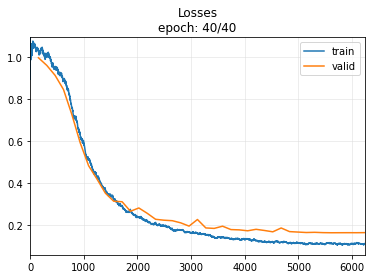

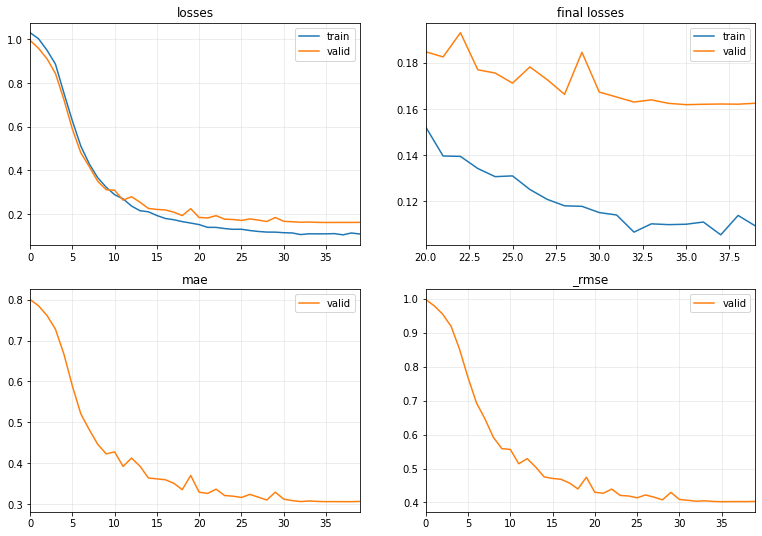

In [41]:
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn.fit_one_cycle(40, 1e-5)

## Model Evaluation & Predict Test Set

In [36]:
def unnorm_y(ser): return (ser*y_raw.std()+y_raw.mean())

probas, _, preds = learn.get_X_preds(X[splits_tsai[1]])
yTarget, yPreds = unnorm_y(y[splits_tsai[1]]), unnorm_y(np.array(preds).flatten())

/usr/local/lib/python3.7/dist-packages/torch/overrides.py:1351: DeprecationWarning: Defining your `__torch_function__ as a plain method is deprecated and will be an error in PyTorch 1.11, please define it as a classmethod.
  DeprecationWarning)


In [49]:
dfRes_ = pd.DataFrame([yTarget, yPreds], index=[f'{TARGET}_actuals',f'{TARGET}_preds']).T
dfRes = pd.merge(dfBp, dfRes_, left_on=TARGET, right_on=f'{TARGET}_actuals').drop_duplicates(INDICIES).set_index(INDICIES)
dfRes = dfRes.assign(fold_number=0)
dfRes

ts         pp         sbp  \
file            heartbeat                                                 
sub019_LLV1.mat 11.0      0 days 00:00:09.480000  69.590997  129.439514   
                12.0      0 days 00:00:10.295000  69.590997  129.439514   
                17.0      0 days 00:00:14.785000  66.759102  130.506767   
                18.0      0 days 00:00:15.565000  66.759102  130.506767   
                20.0      0 days 00:00:17.385000  65.414527  130.982845   
...                                          ...        ...         ...   
sub996_LLV3.mat 21.0      0 days 00:00:26.452000  36.857885   93.837246   
                29.0      0 days 00:00:37.662000  32.885235   96.485998   
                30.0      0 days 00:00:38.807000  32.885235   96.485998   
                43.0      0 days 00:00:53.652000  22.550856   98.251070   
                44.0      0 days 00:00:54.622000  22.550856   98.251070   

                                 dbp     actuals       preds  fold_number  
file            heartbeat                                                  
sub019_LLV1.mat 11.0       59.848517  129.439514  120.073983            0  
                12.0       59.848517  129.439514  120.073983            0  
                17.0       63.747665  130.506767  131.060557            0  
                18.0       63.747665  130.506767  131.060557            0  
                20.0       65.568318  130.982845  126.057757            0  
...                              ...         ...         ...          ...  
sub996_LLV3.mat 21.0       56.979361   93.837246  100.978509            0  
                29.0       63.600763   96.485998  104.810743            0  
                30.0       63.600763   96.485998  104.810743            0  
                43.0       75.700214   98.251070   98.105280            0  
                44.0       75.700214   98.251070   98.105280            0  

[1044 rows x 7 columns]

# Run in Loop

In [ ]:
STOP_HERE

NameError: ignored

processing data...


...data processed
concatenating X...
...X concatenated
concatenating y...
...y concatenated


epoch,train_loss,valid_loss,mae,_rmse,time
0,1.008316,1.018305,0.811413,1.009111,00:03
1,0.965423,0.994233,0.801214,0.997113,00:03
2,0.960782,0.959145,0.787575,0.979359,00:03
3,0.907763,0.899623,0.764542,0.948485,00:03
4,0.789810,0.793915,0.712931,0.891019,00:03
5,0.692002,0.652667,0.634443,0.807878,00:04
6,0.548182,0.534912,0.561622,0.731377,00:05
7,0.449323,0.460647,0.518035,0.678710,00:03
8,0.386055,0.407323,0.486488,0.638219,00:03
9,0.345313,0.446060,0.519304,0.667877,00:04


/usr/local/lib/python3.7/dist-packages/torch/overrides.py:1351: DeprecationWarning: Defining your `__torch_function__ as a plain method is deprecated and will be an error in PyTorch 1.11, please define it as a classmethod.
  DeprecationWarning)


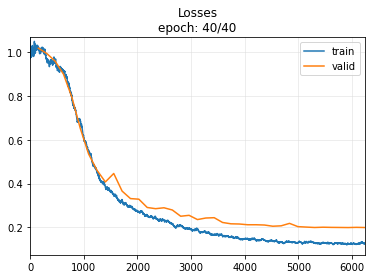

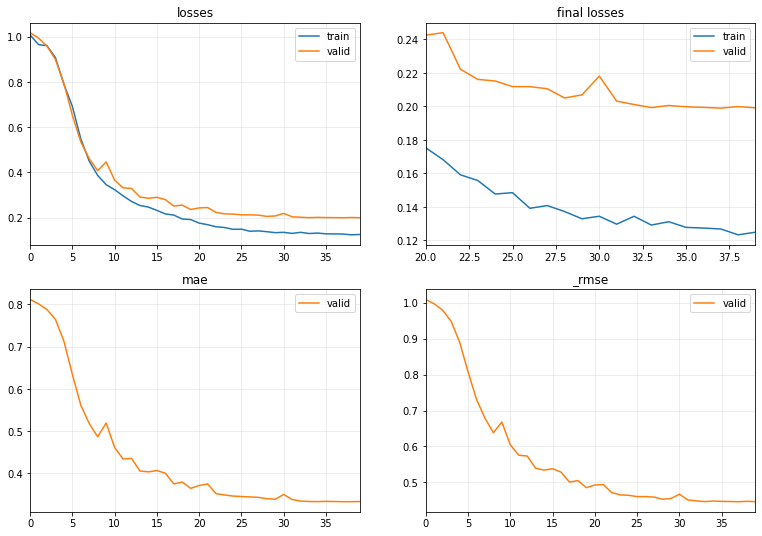

/usr/local/lib/python3.7/dist-packages/torch/overrides.py:1351: DeprecationWarning: Defining your `__torch_function__ as a plain method is deprecated and will be an error in PyTorch 1.11, please define it as a classmethod.
  DeprecationWarning)


ts         pp         sbp  \
file            heartbeat                                                 
sub019_LLV1.mat 3.0       0 days 00:00:02.335000  69.246229  132.744102   
                4.0       0 days 00:00:03.110000  69.246229  132.744102   
                5.0       0 days 00:00:04.110000  67.197150  129.104184   
                6.0       0 days 00:00:04.910000  67.197150  129.104184   
                7.0       0 days 00:00:05.810000  71.791026  133.126552   
...                                          ...        ...         ...   
sub996_LLV3.mat 35.0      0 days 00:00:44.782000  28.704069   96.754846   
                36.0      0 days 00:00:45.777000  28.704069   96.754846   
                37.0      0 days 00:00:46.982000  23.421829   97.025648   
                42.0      0 days 00:00:52.542000  24.147567   96.697222   
                43.0      0 days 00:00:53.552000  24.147567   96.697222   

                                 dbp  dbp_actuals  dbp_preds  fold_number  
file            heartbeat                                                  
sub019_LLV1.mat 3.0        63.497873    63.497873  61.390663            0  
                4.0        63.497873    63.497873  61.390663            0  
                5.0        61.907035    61.907035  63.594352            0  
                6.0        61.907035    61.907035  63.594352            0  
                7.0        61.335526    61.335526  62.443073            0  
...                              ...          ...        ...          ...  
sub996_LLV3.mat 35.0       68.050777    68.050777  76.281425            0  
                36.0       68.050777    68.050777  76.281425            0  
                37.0       73.603819    73.603819  66.274141            0  
                42.0       72.549655    72.549655  72.564945            0  
                43.0       72.549655    72.549655  72.564945            0  

[3759 rows x 7 columns]

In [51]:
from tsai.data.preparation import SlidingWindowPanelSplitter

TARGET = 'dbp'

arrX = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
arrY = [TARGET]
dfReind[arrX + arrY] = dfReind[arrX + arrY].fillna(method='ffill').fillna(method='bfill')
# https://timeseriesai.github.io/tsai//data.preparation#SlidingWindowPanel
# X, y = SlidingWindowPanel(600, unique_id_cols=['file'], stride=200, 
X, y = SlidingWindowPanelSplitter(window_len=190, unique_id_cols=['file'], stride=100, 
                                  get_x=arrX,
                                  get_y=[TARGET])(dfReind)

splits_tsai = TrainValidTestSplitter(valid_size=0.2, shuffle=True)(y)

# Normalize y's
y_raw = y.copy()
y = (y - y.mean()) / y.std()
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_var=True)
dls = get_ts_dls(X, y, splits=splits_tsai, tfms=tfms, batch_tfms=batch_tfms, bs=64)
# dls = get_ts_dls(X, y, tfms=tfms, batch_tfms=batch_tfms, bs=5)

X.shape, y.shape
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn.fit_one_cycle(20, 1e-5)
def unnorm_y(ser): return (ser*y_raw.std()+y_raw.mean())

probas, _, preds = learn.get_X_preds(X[splits_tsai[1]])
yTarget, yPreds = unnorm_y(y[splits_tsai[1]]), unnorm_y(np.array(preds).flatten())
dfRes_ = pd.DataFrame([yTarget, yPreds], index=[f'{TARGET}_actuals',f'{TARGET}_preds']).T
dfRes = pd.merge(dfBp, dfRes_, left_on=TARGET, right_on=f'{TARGET}_actuals').drop_duplicates(INDICIES).set_index(INDICIES)
dfRes = dfRes.assign(fold_number=0)
dfRes

In [ ]:
dfResults = dfResults1\
  .merge(dfResults2, left_index=True, right_index=True, suffixes=('','_drop1'))\
  .merge(dfResults3, left_index=True, right_index=True, suffixes=('','_drop2'))\
  .assign(**{
      'experiment_id' : id,
      'pipeline' : ', '.join([i[0] for i in pipeVectRF.steps])
  })

dfResults = dfResults.drop(columns=dfResults.columns[dfResults.columns.str.contains('_drop')])
dfResults = dfResults.reset_index()
dfResults.file = dfResults.file.str.extract(pat='/[0-9]+_CCs_(sub[0-9]+_\w+).mat$')


# Sklearn Pipeline

## Wrap Model as Sklearn Pipeline

In [ ]:
from sklearn.base import BaseEstimator

# https://scikit-learn.org/stable/developers/develop.html
class TSAI_InceptionTime(BaseEstimator):
  def __init__(self, target='sbp'):
    self.target = target

  def setup_dls(self, X, y):
    tfms  = [None, [TSRegression()]]
    batch_tfms = TSStandardize(by_var=True)
    splits = TrainValidTestSplitter(valid_size=0.2, shuffle=True)(y)

    dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=20)
    return dls


  def fit(self, X, y):
    print('TSAI.fit X', X.dtype, X.shape)
    print('TSAI.fit y', y.dtype, y.shape)
    
    X = X[:,1:,:].astype(np.float32)
    y = y.values
    
    print('TSAI.fit X', X.dtype, X.shape)
    print('TSAI.fit y', y.dtype, y.shape)
    self.y_train = y
    y = (y - y.mean()) / y.std()

    self.dls = self.setup_dls(X, y)
    
    self.learn = ts_learner(self.dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
    self.learn.fit_one_cycle(10, 1e-3)

    return self

  def predict(self, X):
    # X = X[:,:,1:].astype(np.float32)
    X = X[:,1:,:].astype(np.float32)
    
    probas, _, preds = self.learn.get_X_preds(X)
    yPreds = self.unnorm_y(np.array(preds).flatten())
    return np.array(yPreds).clip(40,180)
    

  def unnorm_y(self, ser):
    return (ser*self.y_train.std()+self.y_train.mean())

  ## TODO : proper scoring method
  ## TODO : also this breaks the mvd method somehow?
  def score(self, rows, y):
    # return 1
    return np.abs((self.predict(rows))-y).fillna(0).mean()

## Get Splits for Experiment

In [ ]:
reload(experiments)
# splits = experiments.split_by_random(dfImu, dfBp)
# splits = experiments.split_by_group('file', dfImu, dfBp)

splits = experiments.split_by_query(trainQ='heartbeat < 30', testQ='heartbeat > 30', dfImu=dfImu, dfBp=dfBp, )
# objExperimentDfs = experiments.get_experiment(splits[0], dfImu, dfBp)
# objExperimentDfs['train_y'].groupby(INDICIES, sort=False)['sbp'].mean()
# objExperimentDfs['train_x'].drop(, errors='ignore')

## Train & Test TSAI Pipeline

In [ ]:
reload(experiments); reload(preprocess)
from models import baselines
import sklearn.pipeline
tsExplodeTransform = preprocess.FunctionTransformer(partial(preprocess.explode_3d, data_cols=IMU_DATA_COLS))
tsReshape = preprocess.FunctionTransformer(lambda x : x.transpose(0,2,1))
# pipe = sklearn.pipeline.Pipeline([('transform', tsExplodeTransform), ('model', baselines.DummyRegressor())])
pipe = sklearn.pipeline.Pipeline([('transform', tsExplodeTransform),('transform-reshape', tsReshape), ('model', TSAI_InceptionTime())])

rfResults = experiments.testPipeline(dfImu, dfBp, pipe, splits, targetCol='sbp', verbose=True)
dfResults = experiments.resultsToDf(rfResults)
dfResults.plot.scatter('sbp','preds', title='Random Forest Model')